Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 22)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        49,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 1)          │           101 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,701 (506.64 KB)

 Trainable params: 129,701 (506.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 91s 71ms/step - loss: 0.0141 - val_loss: 0.0264
Epoch 2/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 80s 68ms/step - loss: 0.0117 - val_loss: 0.0179
Epoch 3/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - loss: 0.0111 - val_loss: 0.0203
Epoch 4/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 81s 68ms/step - loss: 0.0106 - val_loss: 0.0177
Epoch 5/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 81s 68ms/step - loss: 0.0102 - val_loss: 0.0167
Epoch 6/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - loss: 0.0098 - val_loss: 0.0157
Epoch 7/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - loss: 0.0095 - val_loss: 0.0171
Epoch 8/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - loss: 0.0095 - val_loss: 0.0163
Epoch 9/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - loss: 0.0094 - val_loss: 0.0177
Epoch 10/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 80s 67ms/step - loss: 0.0091 - val_loss: 0.0169
Epoch 11/50
1189/1189 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - loss: 0.0091 - val_loss: 0.0165
Epoch 12

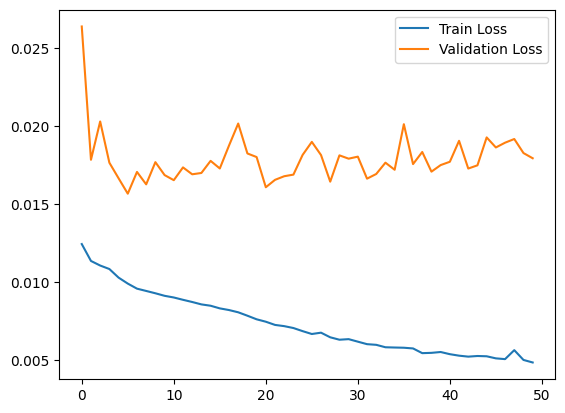

166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Concatenate, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt


# Path to combined data Excel file
file_path = '/content/combined_AQI.xlsx'

# Load combined dataset
df = pd.read_excel(file_path)

# Convert date column
df['date'] = pd.to_datetime(df['date'])

# Extract date features
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.day_name()
df['year'] = df['date'].dt.year

# Drop rows with missing AQI
df = df.dropna(subset=['aqi']).reset_index(drop=True)

# Encode city as one-hot
city_encoder = OneHotEncoder(sparse_output=False)
city_oh = city_encoder.fit_transform(df['city'].values.reshape(-1,1))

# Encode weekday as one-hot
weekday_encoder = OneHotEncoder(sparse_output=False)
weekday_oh = weekday_encoder.fit_transform(df['weekday'].values.reshape(-1,1))

# Prepare feature matrix
features = np.concatenate([
    df['aqi'].values.reshape(-1,1),      # AQI
    city_oh,                            # City one-hot
    weekday_oh                         # Weekday one-hot
], axis=1)

# Scale only AQI column (first column)
scaler = MinMaxScaler(feature_range=(0,1))
features[:,0:1] = scaler.fit_transform(features[:,0:1])

SEQ_LENGTH = 30
PRED_LENGTH = 60
TRAIN_RATIO = 0.8

def create_sequences_multivariate(data, input_seq_length, output_seq_length):
    xs = []
    ys = []
    for i in range(len(data) - input_seq_length - output_seq_length + 1):
        x = data[i:(i+input_seq_length), :]
        y = data[(i+input_seq_length):(i+input_seq_length+output_seq_length), 0]  # predict AQI only
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences_multivariate(features, SEQ_LENGTH, PRED_LENGTH)

# Split train/test
train_size = int(len(X) * TRAIN_RATIO)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape y to [samples, timesteps, features=1]
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

# Build model using functional API to accept multivariate input
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Model

inputs = Input(shape=(SEQ_LENGTH, features.shape[1]))
encoder = LSTM(100, activation='relu')(inputs)
decoder = RepeatVector(PRED_LENGTH)(encoder)
decoder = LSTM(100, activation='relu', return_sequences=True)(decoder)
outputs = TimeDistributed(Dense(1))(decoder)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_split=0.1,
    verbose=1
)

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Predict on test
y_pred = model.predict(X_test)

# Inverse scale AQI for visualization
y_test_orig = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()



Enter city name: pune
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Test RMSE for Pune: 48.94


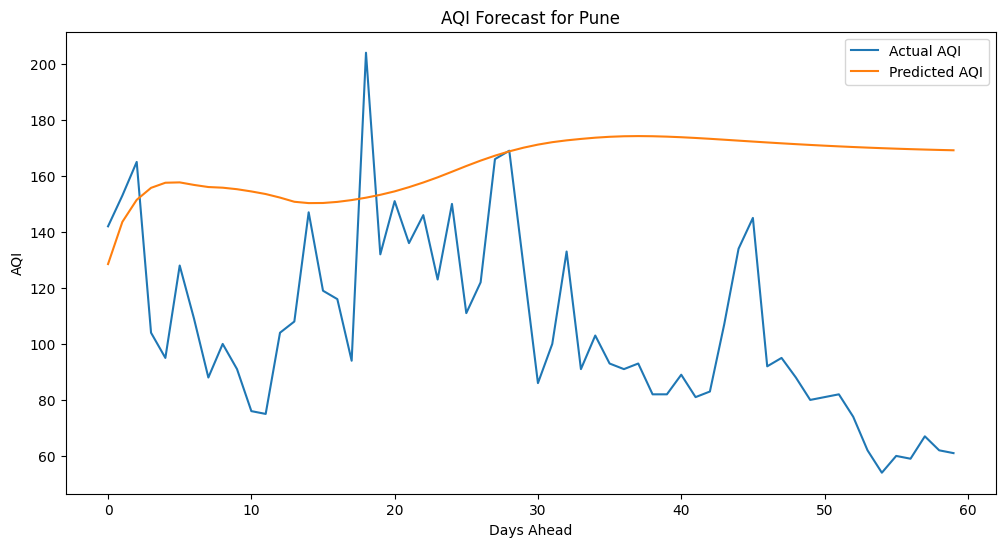

In [ ]:
def predict_for_city(city_name):
    city_name = city_name.title()
    city_data = df[df['city'] == city_name].copy()
    if len(city_data) < SEQ_LENGTH + PRED_LENGTH:
        print(f"Not enough data for city {city_name} to predict. Need at least {SEQ_LENGTH + PRED_LENGTH} days.")
        return

    # Encode city and weekday for city data
    city_oh = city_encoder.transform(city_data['city'].values.reshape(-1,1))
    weekday_oh = weekday_encoder.transform(city_data['weekday'].values.reshape(-1,1))

    # Prepare features
    features = np.concatenate([
        city_data['aqi'].values.reshape(-1,1),
        city_oh,
        weekday_oh
    ], axis=1)

    # Scale AQI column
    features[:,0:1] = scaler.transform(features[:,0:1])

    # Create sequences for prediction
    X_city, y_city = create_sequences_multivariate(features, SEQ_LENGTH, PRED_LENGTH)

    if len(X_city) == 0:
        print(f"Not enough sequences to predict for city {city_name}.")
        return

    y_city = y_city.reshape((y_city.shape[0], y_city.shape[1], 1))

    # Predict AQI
    y_pred = model.predict(X_city)

    # Inverse scale AQI
    y_true_orig = scaler.inverse_transform(y_city.reshape(-1,1)).flatten()
    y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    print(f"Test RMSE for {city_name}: {rmse:.2f}")

    # Plot first prediction example
    plt.figure(figsize=(12,6))
    plt.plot(range(PRED_LENGTH), y_true_orig[:PRED_LENGTH], label='Actual AQI')
    plt.plot(range(PRED_LENGTH), y_pred_orig[:PRED_LENGTH], label='Predicted AQI')
    plt.title(f'AQI Forecast for {city_name}')
    plt.xlabel('Days Ahead')
    plt.ylabel('AQI')
    plt.legend()
    plt.show()

# User input
user_city = input("Enter city name: ").title()
predict_for_city(user_city)


In [ ]:
# Save the model in the native Keras format
model.save('/content/aqi_lstm_model.keras')
print("Model saved successfully in the latest format!")


Model saved successfully in the latest format!


In [ ]:
from google.colab import files

files.download('/content/aqi_lstm_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>